<a href="https://colab.research.google.com/github/youssouf2230/Base_de_r-seau_de_neuron_avec_np/blob/main/R%C3%A9seaux_de_neurones_multi_couches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

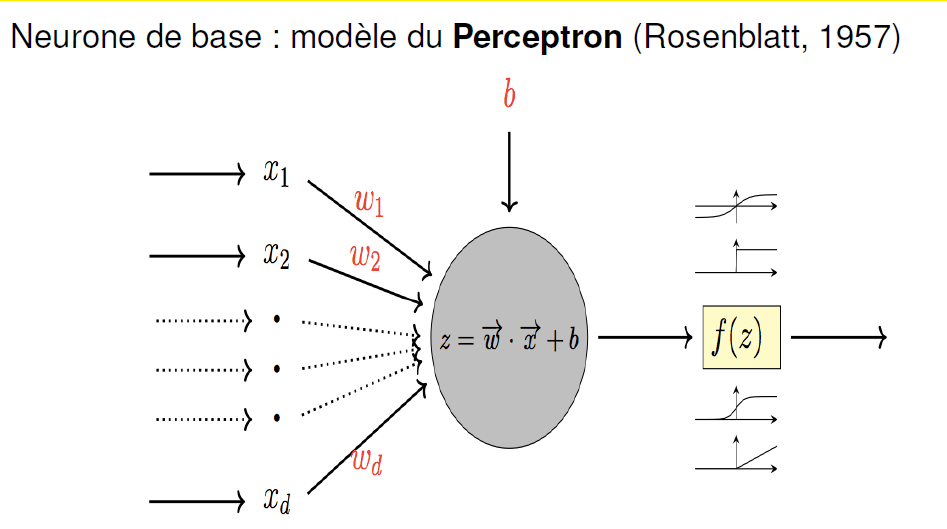

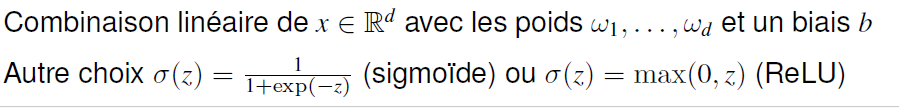

Construire un réseau de neurons **multi-classes** à partir de zéro

In [3]:
import numpy as np

# parems initialization
def init_params(layer_dims):
    """
    Initialise les paramètres d'un réseau de neurones.
    layer_dims : liste contenant le nombre de neurones dans chaque couche
                 (ex: [n_x, n_h1, n_h2, n_y])
    Retourne :
        params : dictionnaire contenant W1, b1, ..., WL, bL
    """
    np.random.seed(42)
    params = {}
    L = len(layer_dims)

    for l in range(1, L):
        params[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        params[f"b{l}"] = np.zeros((layer_dims[l], 1))

    return params


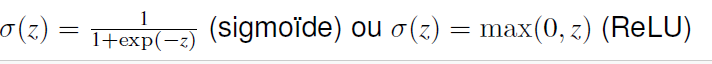

In [4]:
def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    if activation == "relu":
        A = np.maximum(0, Z)
    elif activation == "sigmoid":
        A = 1 / (1 + np.exp(-Z))
    cache = (A_prev, W, b, Z)
    return A, cache


In [5]:
# modele forward
# modele forward
def model_forward(X, params):
    caches = []
    A = X
    L = len(params) // 2

    # couches cachées avec ReLU
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params[f"W{l}"], params[f"b{l}"], "relu")
        caches.append(cache)

    # couche de sortie avec Sigmoid (si binaire) ou Softmax (si multi-classes)
    A, cache = linear_activation_forward(A, params[f"W{L}"], params[f"b{L}"], "sigmoid")
    caches.append(cache)

    return A, caches


In [6]:
# loss
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1/m * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    return np.squeeze(cost)


In [7]:
def linear_backward(dZ, cache):
    A_prev, W, b, Z = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db


In [8]:

# back propagation combine avec activation
def linear_activation_backward(dA, cache, activation):
    A_prev, W, b, Z = cache

    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    elif activation == "sigmoid":
        s = 1 / (1 + np.exp(-Z))
        dZ = dA * s * (1 - s)

    dA_prev, dW, db = linear_backward(dZ, cache)
    return dA_prev, dW, db



In [9]:
def model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # dernière couche (sigmoid)
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[-1]
    grads[f"dA{L-1}"], grads[f"dW{L}"], grads[f"db{L}"] = linear_activation_backward(dAL, current_cache, "sigmoid")

    # couches cachées (relu)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads[f"dA{l+1}"], current_cache, "relu")
        grads[f"dA{l}"] = dA_prev_temp
        grads[f"dW{l+1}"] = dW_temp
        grads[f"db{l+1}"] = db_temp

    return grads


In [10]:
def update_params(params, grads, learning_rate):
    L = len(params) // 2
    for l in range(1, L+1):
        params[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        params[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    return params


In [26]:
def model(X, Y, layer_dims, learning_rate=0.01, iterations=1000):
    # init params
    params = init_params(layer_dims)
    # cost
    loss = []

    for i in range(iterations):
        # forward
        AL, caches = model_forward(X, params)
        # cost
        cost = compute_cost(AL, Y)
        loss.append(cost)
        # backward
        grads = model_backward(AL, Y, caches)
        # update
        params = update_params(params, grads, learning_rate)

        if i % 100 == 0:
            print(f"Iteration {i}: cost = {cost:.4f}")
    return params,loss


In [27]:
 #  Évaluer le modèle sur train et test
def predict(X, params):
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0, Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))
    return (A2 > 0.5).astype(int)


In [29]:
# import data set iris via sklearn
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer


In [30]:
data = load_breast_cancer()
X = data.data
y = data.target


In [18]:

import matplotlib.pyplot as plt

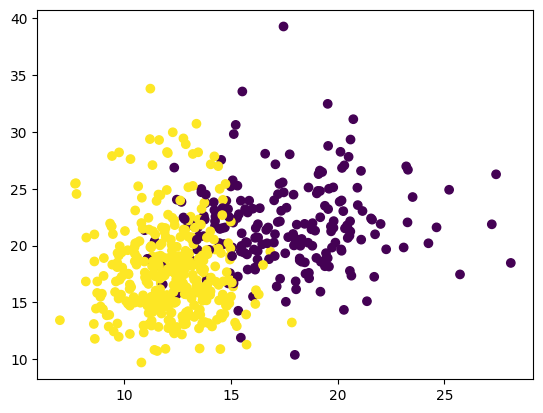

In [19]:
# play data with matplotlib
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#  Normaliser
scaler = StandardScaler()
X = scaler.fit_transform(X)

#  Diviser en train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  Reshape correct (ton modèle attend X.T et y (1, m))
X_train = X_train.T       # (30, m_train)
X_test = X_test.T         # (30, m_test)
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (30, 455)
y_train: (1, 455)
X_test: (30, 114)
y_test: (1, 114)


In [32]:
#  Définir les dimensions du réseau
layer_dims = [X_train.shape[0], 5, 1]

#  Entraîner le modèle
params, loss = model(X_train, y_train, layer_dims, learning_rate=0.01, iterations=1000)



# Prédictions
y_pred_train = predict(X_train, params)
y_pred_test = predict(X_test, params)

# Précision
acc_train = np.mean(y_pred_train == y_train)
acc_test = np.mean(y_pred_test == y_test)

print(f"\nAccuracy entraînement : {acc_train*100:.2f}%")
print(f"Accuracy test : {acc_test*100:.2f}%")

Iteration 0: cost = 0.6931
Iteration 100: cost = 0.6802
Iteration 200: cost = 0.6715
Iteration 300: cost = 0.6618
Iteration 400: cost = 0.6376
Iteration 500: cost = 0.5602
Iteration 600: cost = 0.4208
Iteration 700: cost = 0.2984
Iteration 800: cost = 0.2214
Iteration 900: cost = 0.1767

Accuracy entraînement : 96.92%
Accuracy test : 94.74%


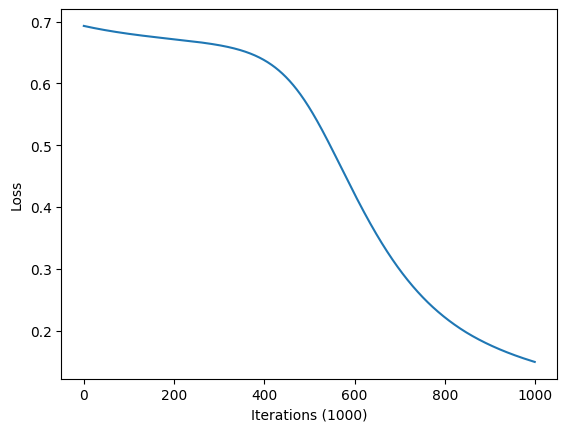

In [34]:
# afficher loss
plt.plot(loss)
plt.xlabel("Iterations (1000)")
plt.ylabel("Loss")
plt.show()